In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from itertools import product

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment, random_py_environment, random_tf_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common

from tf_agents.networks import encoding_network


from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.networks.utils import BatchSquash
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer, episodic_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.utils import common as common_utils
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec

import collections

import gin
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
from tf_agents.agents import tf_agent
from tf_agents.policies import boltzmann_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import q_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.utils import composite
from tf_agents.utils import eager_utils
from tf_agents.utils import nest_utils
from tf_agents.utils import training as training_lib
from tf_agents.utils import value_ops
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.reinforce import reinforce_agent




import matplotlib.pyplot as plt

import tensorflow as tf

tf.compat.v1.enable_v2_behavior()

In [2]:
class MM1NQueue(object):
    '''
    define a M/M/1/N queue, where N = max queue size
    '''
    def __init__(self, ini_num_pkt, max_num_pkt, arrival_rate, service_rate):
        self.ini_num_pkt = ini_num_pkt
        self.max_num_pkt = max_num_pkt
        self.arrival_rate = float(arrival_rate)
        self.service_rate = float(service_rate)

    def reset_ini_num_pkt(self, ini_num_pkt):
        '''
        reset the initial number of packets
        '''
        self.ini_num_pkt = ini_num_pkt

    def run_one_unit_time(self):
        '''
        run the queue for one unit time and return the (queue_length, num_sevice) tuple
        '''
        queue_length = self.ini_num_pkt
        time = 0
        num_service = 0
        while True:
            t_arrival = np.random.exponential(scale=1/self.arrival_rate)
            t_service = np.random.exponential(scale=1/self.service_rate)
            if t_arrival > t_service:
                time = time + t_service
                if time > 1:
                    break
                if queue_length:
                    num_service += 1
                    queue_length -= 1
            else:
                time = time + t_arrival
                if time > 1:
                    break
                queue_length = min(self.max_num_pkt, queue_length+1)
        return queue_length, num_service

    def run_multiple_unit_slots(self):
        '''
        invoke self.run_one_unit_time multiple times and obtain the following
        statistics:
        end_queue_length_frequency: a list with size self.max_num_pkt+1,
                                    end_queue_length_frequency[n] is the frequency
                                    of the queue length = n at the end of one unit time
        average_num_service: the average number of services at the end of one unit time
        '''
        end_queue_length_frequency = np.array([0]*(self.max_num_pkt+1), dtype=float)
        average_num_service = 0.0
        num_runs = 100
        for _ in range(num_runs):
            (queue_length, num_service) = self.run_one_unit_time()
            end_queue_length_frequency[queue_length] += 1
            average_num_service += num_service
        average_num_service = average_num_service/num_runs
        end_queue_length_frequency = end_queue_length_frequency/float(num_runs)
        return (end_queue_length_frequency, average_num_service)

In [3]:
class CarRentalEnv(py_environment.PyEnvironment):
    def __init__(self, locations=2, max_cars=20, max_days=10, max_move=5):
        self.locations = locations
        self.max_cars = max_cars
        self.max_days = max_days

        self._action_spec = array_spec.BoundedArraySpec(shape=(),
                                                        dtype=np.int32,
                                                        minimum = 0,
                                                        maximum = max_move,
                                                        name='action')

        self._observation_spec = array_spec.BoundedArraySpec(shape=(locations,),
                                                             dtype=np.int32,
                                                             minimum=np.zeros(locations, dtype=np.int32),
                                                             maximum=np.ones(locations, dtype=np.int32)*max_cars,
                                                             name='observation')

        self._state = np.zeros(locations, dtype=np.int32)
        self._episode_ended = False
        self._num_days = 0

        self.location_queues = []
        self.expected_rewards = []

        self.location_queues.append(MM1NQueue(0, max_cars+1, 5, 4))
        self.expected_rewards.append(np.zeros(shape=(self.max_cars + 1)))
        
        self.location_queues.append(MM1NQueue(0, max_cars+1, 1, 5))
        self.expected_rewards.append(np.zeros(shape=(self.max_cars + 1)))

        self.calc_all_rewards()

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state[0] = 10
        self._state[1] = 10
        self._episode_ended = False
        self._num_days = 0
        return ts.restart(np.array(self._state, dtype=np.int32))

    def _step(self, action):

        if self._episode_ended:
            return self.reset()

        self.move(action)
        reward = self.get_daily_reward(action)

        self._num_days += 1

        if self.game_over():
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            return ts.transition(
                np.array(self._state, dtype=np.int32), reward=reward, discount=0.9)

    def calc_all_rewards(self):
        '''
        Reward of a morning state.
        '''
        for i, queue in enumerate(self.location_queues):
            for ini_num_car in range(self.max_cars + 1):
                queue.reset_ini_num_pkt(ini_num_car)
                probs, reward = queue.run_multiple_unit_slots()
                self.expected_rewards[i][ini_num_car] = reward

    def get_daily_reward(self, action):
        """Gets the reward after a move has been made"""
        total_reward = 0.
        for loc in range(self.locations):
            num_cars = int(self._state[loc])
            total_reward += 10*self.expected_rewards[loc][num_cars] - 2*np.abs(action)
        return total_reward

    def move(self, action):
        """
        """
        self._state[0] -= action
        self._state[1] += action

        self._state = np.clip(self._state, a_min = 0, a_max = self.max_cars)

    def game_over(self):
        return self._num_days > self.max_days

In [4]:
locations = 2

env1 = CarRentalEnv(locations)
# utils.validate_py_environment(env, episodes=2)

train_env = tf_py_environment.TFPyEnvironment(env1)

env2 = CarRentalEnv(locations)
env2.location_queues = env1.location_queues
env2.expected_rewards = env1.expected_rewards

# utils.validate_py_environment(env2, episodes=2)
eval_env = tf_py_environment.TFPyEnvironment(env2)

In [5]:
time_step = train_env.reset()
    
for i in range(20):
    print("Current state: ", time_step.observation.numpy(), "Current reward:", time_step.reward)
    action = np.random.randint(-5, 5)
    print("Action: ", action)
    time_step = train_env.step(action)

Current state:  [[10 10]] Current reward: tf.Tensor([0.], shape=(1,), dtype=float32)
Action:  -3
Current state:  [[13  7]] Current reward: tf.Tensor([80.6], shape=(1,), dtype=float32)
Action:  -1
Current state:  [[14  6]] Current reward: tf.Tensor([84.4], shape=(1,), dtype=float32)
Action:  -5
Current state:  [[19  1]] Current reward: tf.Tensor([36.4], shape=(1,), dtype=float32)
Action:  -4
Current state:  [[20  0]] Current reward: tf.Tensor([30.7], shape=(1,), dtype=float32)
Action:  2
Current state:  [[18  2]] Current reward: tf.Tensor([56.4], shape=(1,), dtype=float32)
Action:  -2
Current state:  [[20  0]] Current reward: tf.Tensor([38.7], shape=(1,), dtype=float32)
Action:  1
Current state:  [[19  1]] Current reward: tf.Tensor([52.4], shape=(1,), dtype=float32)
Action:  -1
Current state:  [[20  0]] Current reward: tf.Tensor([42.7], shape=(1,), dtype=float32)
Action:  -4
Current state:  [[20  0]] Current reward: tf.Tensor([30.7], shape=(1,), dtype=float32)
Action:  0
Current state: 

In [6]:
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

In [7]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [8]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [9]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

num_eval_episodes = 2
#compute_avg_return(eval_env, random_policy, num_eval_episodes)

In [12]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [13]:

def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1


In [14]:
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 25: loss = 1.1034411191940308
step = 50: loss = 0.8009939193725586
step = 50: Average Return = 903.5
step = 75: loss = 2.451096534729004
step = 100: loss = 2.5155601501464844
step = 100: Average Return = 903.5
step = 125: loss = 2.869663715362549
step = 150: loss = -1.765895962715149
step = 150: Average Return = 903.5
step = 175: loss = 3.6954517364501953
step = 200: loss = 0.48894238471984863
step = 200: Average Return = 903.5
step = 225: loss = 1.983219027519226
step = 250: loss = 0.5128098726272583
step = 250: Average Return = 903.5


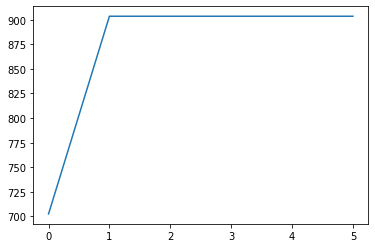

In [15]:
plt.plot(returns)

In [17]:
time_step = train_env.reset()
print(time_step.observation)

for i in range(10):
    print("State:", time_step.observation)
    action_step = tf_agent.policy.action(time_step)
    print("Action:", action_step.action)
    time_step = train_env.step(action_step.action)

tf.Tensor([[10 10]], shape=(1, 2), dtype=int32)
State: tf.Tensor([[10 10]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 9 11]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 8 12]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 7 13]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 6 14]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 5 15]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 4 16]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 3 17]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 2 18]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[ 1 19]